In [1]:
import pandas as pd
import datetime
from tqdm import tqdm
import re
# from IPython.core.pylabtools import figsize
import optuna
import operator
import numpy as np
import matplotlib.pyplot as plt
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)


import numpy as np
import pandas as pd
import scipy.stats as stats
import sklearn
# import statsmodels.api as sm

# import seaborn as sns
# sns.set_style("whitegrid")
# sns.set_context("poster")

# special matplotlib argument for improved plots
#from matplotlib import rcParams
from sklearn.model_selection import train_test_split

import requests
from datetime import timedelta

c:\Users\Admin\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<IPython.core.display.Javascript object>

In [2]:
def test_live(sample_duration):
    def vn30f():
        return requests.get("https://services.entrade.com.vn/chart-api/chart?from=1651727820&resolution=1&symbol=VN30F1M&to=9999999999").json()
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    s = pd.read_csv('C:\python\VN30F1M.csv')
    s['Date'] = pd.to_datetime(s['Date']) + timedelta(hours =7)
    ohlc_dict = {                                                                                                             
        'Open': 'first',                                                                                                    
        'High': 'max',                                                                                                       
        'Low': 'min',                                                                                                        
        'Close': 'last',                                                                                                    
        'Volume': 'sum',}
    vn30fm = pd.DataFrame(vn30f()).iloc[:,:6]
    vn30fm['t'] = vn30fm['t'].astype(int).apply(lambda x: datetime.datetime.utcfromtimestamp(x) + timedelta(hours = 7))
    vn30fm.columns = ['Date','Open','High','Low','Close','Volume']
    def process_data(input_df):
        vn30train = pd.DataFrame(input_df.resample(str(sample_duration)+'Min', on='Date', label='left').apply(ohlc_dict).dropna()).reset_index()#change s
        vn30train['Date'] = [str(i)[:16] for i in vn30train['Date']]
        return vn30train
    vn30f_base = pd.concat([process_data(vn30fm), process_data(s)]).sort_values('Date').drop_duplicates('Date').sort_values('Date')
    return vn30f_base

In [3]:
data = test_live(15)

dff = data[['Date', 'Open']]
dff['Date'] = pd.to_datetime(dff['Date'])
dff['Date'].apply(lambda x:x.hour)
df1 = dff.loc[(dff['Date'].apply(lambda x:x.minute)==00)&(dff['Date'].apply(lambda x:x.hour)==9)]
df1.Date = [str(i)[:10] for i in df1.Date]

df = data[['Date', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df['Date'].apply(lambda x:x.hour)
df2 = df.loc[(df['Date'].apply(lambda x:x.minute)==15)&(df['Date'].apply(lambda x:x.hour)==9)]
df2.Date = [str(i)[:10] for i in df2.Date]

df3 = df.loc[(df['Date'].apply(lambda x:x.minute)==30)&(df['Date'].apply(lambda x:x.hour)==9)]
df3.Date = [str(i)[:10] for i in df3.Date]

df4 = df.loc[(df['Date'].apply(lambda x:x.minute)==00)&(df['Date'].apply(lambda x:x.hour)==10)]
df4.Date = [str(i)[:10] for i in df4.Date]

ds = df1.merge(df2, how = 'inner', on = 'Date').merge(df3, how = 'inner', on = 'Date').merge(df4, how = 'inner', on = 'Date')
ds.columns = ['Date', 'Open', '9:15', '9:30', '10:00']

df10 = data[['Date', 'Low']]
df10['Date'] = pd.to_datetime(df10['Date'])
findlow = df10.loc[(df10['Date'].apply(lambda x:x.hour)>10)]
findlow['Day'] = [str(i)[:10] for i in findlow.Date]


data['Day'] = [str(i)[:10] for i in data.Date]
#high = data[['Day','High']].groupby('Day').max()
low = findlow[['Day','Low']].groupby('Day').min()
#high['Date'] = high.index

low['Date'] = low.index
ds = ds.merge(low, how='inner', on='Date')


C:\Users\Admin\AppData\Local\Temp\ipykernel_6048\3162489782.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['Date'] = pd.to_datetime(dff['Date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_6048\3162489782.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.Date = [str(i)[:10] for i in df1.Date]
C:\Users\Admin\AppData\Local\Temp\ipykernel_6048\3162489782.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

Text(0.5, 1.0, 'Prices vs Predicted prices: $Y_i$ vs $\\hat{Y}_i$')

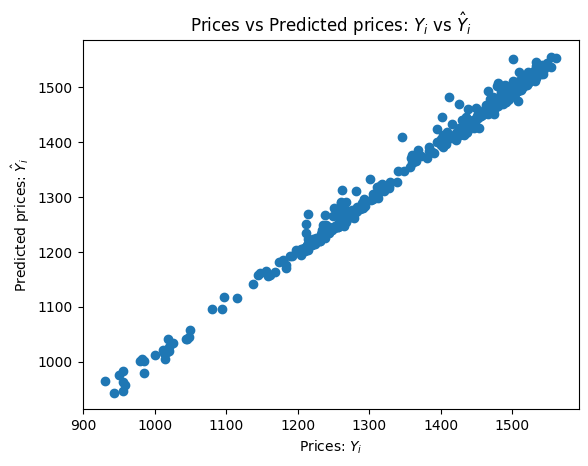

In [4]:
X = ds.drop(['Low', 'Date'], axis = 1)
Y = ds['Low']
X_train = X.loc[:900]
X_test = X.loc[900:]
Y_train = Y.loc[:900]
Y_test = Y.loc[900:]

from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, Y_train)

Y_pred = lm.predict(X_test)

plt.scatter(Y_test, Y_pred)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted prices: $Y_i$ vs $\hat{Y}_i$")

In [13]:
X_train.mean(axis=1)

0       746.250
1       750.025
2       746.775
3       748.200
4       742.500
         ...   
896    1189.875
897    1186.100
898    1207.775
899    1205.250
900    1207.225
Length: 901, dtype: float64

In [9]:
X_test

Open    9:15    9:30   10:00
900   1208.0  1207.3  1208.7  1204.9
901   1195.7  1193.3  1193.0  1194.9
902   1178.2  1174.9  1176.1  1176.8
903   1172.0  1171.3  1166.4  1167.1
904   1164.3  1168.3  1167.3  1167.0
...      ...     ...     ...     ...
1307  1011.0  1011.4  1012.6  1016.8
1308   995.2   987.1   974.2   971.1
1309   981.0   985.4   986.9   982.3
1310   945.6   951.5   951.1   951.1
1311   978.2   980.3   978.2   985.6

[412 rows x 4 columns]

In [6]:
X_test

Open    9:15    9:30   10:00
900   1208.0  1207.3  1208.7  1204.9
901   1195.7  1193.3  1193.0  1194.9
902   1178.2  1174.9  1176.1  1176.8
903   1172.0  1171.3  1166.4  1167.1
904   1164.3  1168.3  1167.3  1167.0
...      ...     ...     ...     ...
1307  1011.0  1011.4  1012.6  1016.8
1308   995.2   987.1   974.2   971.1
1309   981.0   985.4   986.9   982.3
1310   945.6   951.5   951.1   951.1
1311   978.2   980.3   978.2   985.6

[412 rows x 4 columns]

In [5]:
Y_test = pd.DataFrame(Y_test)
Y_test['pred'] = Y_pred

ope = data[['Date', 'Open']]
ope['Date'] = pd.to_datetime(ope['Date'])
ope['Date'].apply(lambda x:x.hour)
op = ope.loc[(ope['Date'].apply(lambda x:x.minute)==15)&(ope['Date'].apply(lambda x:x.hour)==10)]
op.Date = [str(i)[:10] for i in op.Date]

Y_test['Date'] = ds.Date.iloc[900:]
Y_test = Y_test.merge(op, how='inner', on='Date')
Y_test.drop('Date', axis = 1)
Y_test['dev'] = Y_test.pred - Y_test.Open
Y_test['Date'] = [str(i)+ ' 10:15' for i in Y_test.Date]
Y_test.Date = [str(i) for i in Y_test.Date]
Y_test

C:\Users\Admin\AppData\Local\Temp\ipykernel_6048\4181403158.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ope['Date'] = pd.to_datetime(ope['Date'])
C:\Users\Admin\AppData\Local\Temp\ipykernel_6048\4181403158.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  op.Date = [str(i)[:10] for i in op.Date]


Low         pred              Date    Open        dev
0    1192.4  1192.478934  2021-03-22 10:15  1204.9 -12.421066
1    1180.0  1184.625985  2021-03-23 10:15  1194.9 -10.274015
2    1155.3  1165.950741  2021-03-24 10:15  1176.8 -10.849259
3    1158.1  1156.837740  2021-03-25 10:15  1167.0 -10.162260
4    1145.1  1158.585240  2021-03-26 10:15  1166.8  -8.214760
..      ...          ...               ...     ...        ...
407  1001.1  1011.490135  2022-11-03 10:15  1017.0  -5.509865
408   958.6   957.747235  2022-11-04 10:15   972.0 -14.252765
409   950.0   974.703127  2022-11-07 10:15   982.2  -7.496873
410   955.6   946.696262  2022-11-08 10:15   951.2  -4.503738
411   956.3   982.712783  2022-11-09 10:15   985.9  -3.187217

[412 rows x 5 columns]

In [596]:
Y_test['accu'] = (Y_test.Low - Y_test.pred)

In [601]:
abs(Y_test.accu)

0       0.078934
1       4.625985
2      10.650741
3       1.262260
4      13.485240
         ...    
406     9.943090
407    10.390135
408     0.852765
409    24.703127
410     8.903738
Name: accu, Length: 411, dtype: float64

In [529]:
Y_test.acu.abs().mean()

0.007075801871693073

100%|██████████| 24881/24881 [00:00<00:00, 68019.26it/s]


<AxesSubplot:>

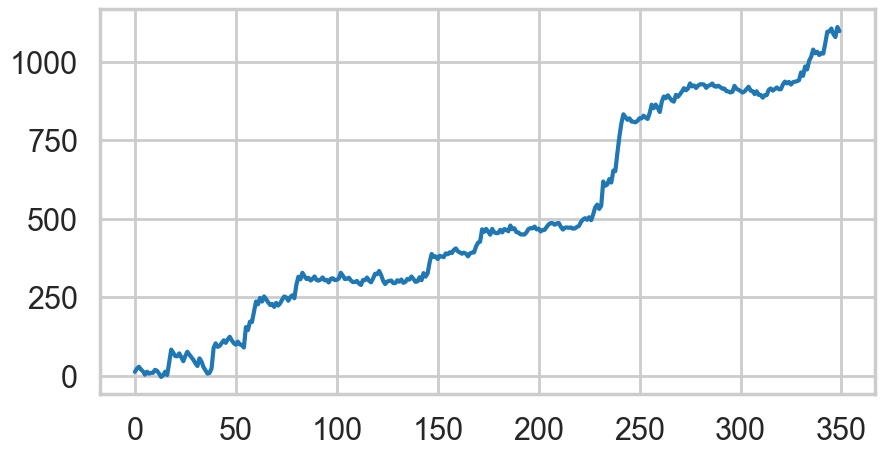

In [567]:
sig = Y_test[['Date', 'dev']]
signal = data.merge(sig, how='left', on='Date')
signal = signal.fillna(0)

buy = 0 
profit = []
date = []
time = 0
position = []
for i in tqdm(range(len(signal))):
    if buy == 0 and signal.dev.iloc[i] < -3.5 and signal.Open.iloc[i] - signal.Close.iloc[i-4] < 4.5:
        buy = signal.Open.iloc[i]
        position.append(1)
        time = i
        date.append(signal.Date.iloc[i])
    if buy != 0 and i - time >= 1:
        if (signal.Open.iloc[i] - buy) > 8 or (i - time) == 13:
            profit.append(buy - signal.Open.iloc[i])
            date.append(signal.Date.iloc[i])
            position.append(0)
            buy = 0
pd.Series(profit).cumsum().plot(figsize = (10,5))

In [531]:
pd.Series(profit).sum()

1096.8000000000002

In [532]:
profit[-1]

-13.5

<AxesSubplot:xlabel='Date'>

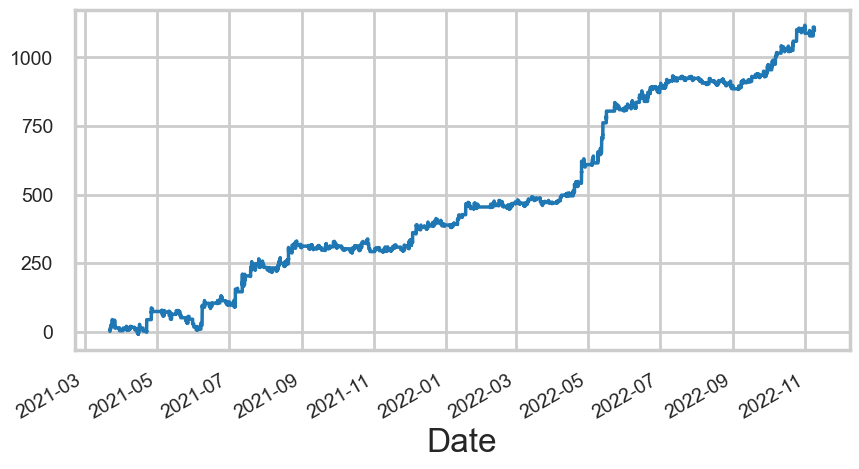

In [533]:
haha = pd.DataFrame()
haha['Date'] = date
haha['pos'] = position
#short
short = data.merge(haha, how = 'left', on='Date')
short = short.fillna(method='pad').dropna()
short.set_index('Date', inplace=True)


plt.figure(figsize=(10,5))
pnl = (-(short['Open'].shift(-1) - short['Open'])*short['pos']).cumsum()
pnl.index = pd.to_datetime(pnl.index)
plt.grid(False)
pnl.plot(fontsize=14, linewidth=2.5)

In [534]:
len(profit)

350

In [535]:
def sharpe(pnl):
    r = pnl.diff()
    return (r.mean()/r.std() * np.sqrt(252))
sharpe(pnl)

0.8504359804606765

In [536]:
Y_test

Low         pred              Date    Open        dev       acu
0    1192.4  1192.478934  2021-03-22 10:15  1204.9 -12.421066 -0.000066
1    1180.0  1184.625985  2021-03-23 10:15  1194.9 -10.274015 -0.003920
2    1155.3  1165.950741  2021-03-24 10:15  1176.8 -10.849259 -0.009219
3    1158.1  1156.837740  2021-03-25 10:15  1167.0 -10.162260  0.001090
4    1145.1  1158.585240  2021-03-26 10:15  1166.8  -8.214760 -0.011776
..      ...          ...               ...     ...        ...       ...
406  1011.9  1021.843090  2022-11-02 10:15  1027.0  -5.156910 -0.009826
407  1001.1  1011.490135  2022-11-03 10:15  1017.0  -5.509865 -0.010379
408   958.6   957.747235  2022-11-04 10:15   972.0 -14.252765  0.000890
409   950.0   974.703127  2022-11-07 10:15   982.2  -7.496873 -0.026003
410   955.6   946.696262  2022-11-08 10:15   951.2  -4.503738  0.009317

[411 rows x 6 columns]

100%|██████████| 24881/24881 [00:00<00:00, 77982.00it/s]


1096.800000000001

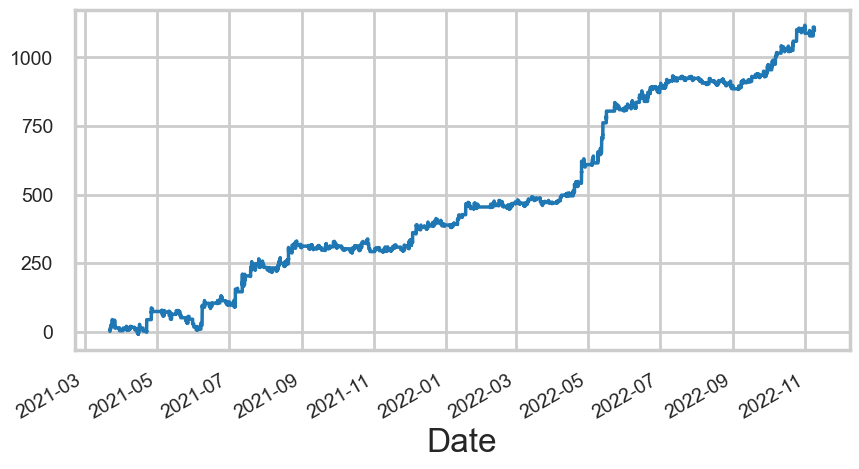

In [446]:
sig = Y_test[['Date', 'dev']]
signal = data.merge(sig, how='left', on='Date')
signal = signal.fillna(0)

ok = Y_test[['Date', 'pred']]
signal = signal.merge(ok, how='left', on='Date')
signal = signal.fillna(method='pad')

buy = 0 
profit = []
date = []
time = 0
position = []
cash = 1209
for i in tqdm(range(len(signal))):
    if buy == 0 and signal.dev.iloc[i] < -3.3 and signal.Open.iloc[i] - signal.Close.iloc[i-4] < 4.5:
        buy = signal.Open.iloc[i]
        position.append(1)
        time = i
        date.append(signal.Date.iloc[i])
    if buy != 0 and i - time >= 1:
        if (signal.Open.iloc[i] - buy) > 8 or (i - time) == 13:
            profit.append(buy - signal.Open.iloc[i])
            date.append(signal.Date.iloc[i])
            position.append(0)
            cash = cash - 0.05 + (buy - signal.Open.iloc[i] )
            buy = 0

haha = pd.DataFrame()
haha['Date'] = date
haha['pos'] = position
#short
short = data.merge(haha, how = 'left', on='Date')
short = short.fillna(method='pad').dropna()
short.set_index('Date', inplace=True)


plt.figure(figsize=(10,5))
pnl = (-(short['Open'].shift(-1) - short['Open'])*short['pos']).cumsum()
pnl.index = pd.to_datetime(pnl.index)
plt.grid(False)
pnl.plot(fontsize=14, linewidth=2.5)
(-(short['Open'].shift(-1) - short['Open'])*short['pos']).cumsum().iloc[-2]

In [537]:
short = data.merge(haha, how = 'left', on='Date')
short = short.fillna(method='pad').dropna()
short.set_index('Date', inplace=True)
short['pos'] = short['pos']*(-1)
data231 = pd.DataFrame(short['pos']*(short['Open'].shift(-1) - short['Open']))
data231['pos'] = abs(short['pos'].diff(1)).cumsum()*0.037
data231['total_gain'] = np.array(data231.iloc[:,0].cumsum())
data231['total_gain'] = data231['total_gain'] - data231['pos']
data231['day'] = np.array([str(i)[:10] for i in data231.index])
abs(short['pos'].diff(1)).cumsum().iloc[-2]

699.0

In [538]:
pnl[-2]

1096.800000000001

In [539]:
maximum_drawdown_future(pnl)

100%|██████████| 7801/7801 [00:04<00:00, 1613.86it/s]


80.79999999999973

In [540]:
profit[-2]

32.200000000000045

In [541]:
pnl[-2]*0.61

669.0480000000007

In [385]:
def maximum_drawdown_future(backtest):
    max_drawdown = 0
    for i in tqdm(range(1, len(backtest))):
        drawdown = (backtest.rolling(i).max().iloc[i] - backtest.iloc[i])
        if drawdown > max_drawdown:
            max_drawdown = drawdown
    return max_drawdown

maximum_drawdown_future(pnl)

100%|██████████| 7801/7801 [00:04<00:00, 1614.60it/s]


0.0661637717121586

In [583]:
short

Date    Open    High     Low   Close   Volume         Day  \
0     2021-03-22 10:15  1204.9  1204.9  1199.1  1199.8  16462.0  2021-03-22   
1     2021-03-22 10:30  1199.1  1202.5  1197.2  1202.0  13129.0  2021-03-22   
2     2021-03-22 10:45  1202.0  1203.8  1199.0  1203.0   8252.0  2021-03-22   
3     2021-03-22 11:00  1203.2  1204.4  1202.2  1202.5   8052.0  2021-03-22   
4     2021-03-22 11:15  1202.3  1204.3  1201.1  1203.6   6103.0  2021-03-22   
...                ...     ...     ...     ...     ...      ...         ...   
7797  2022-11-08 13:30   963.2   970.0   963.2   966.5  35302.0  2022-11-08   
7798  2022-11-08 13:45   966.5   973.8   965.2   971.0  30439.0  2022-11-08   
7799  2022-11-08 14:00   970.6   984.7   969.3   979.0  47741.0  2022-11-08   
7800  2022-11-08 14:15   979.4   979.6   968.8   969.9  41013.0  2022-11-08   
7801  2022-11-08 14:30   970.3   970.3   970.3   970.3    160.0  2022-11-08   

      pos  diff  
0    -1.0   NaN  
1    -1.0  -5.8  
2    -1.0   2.9  
3    -1.0   1.2  
4    -1.0  -0.9  
...   ...   ...  
7797 -0.0  -1.5  
7798 -0.0   3.3  
7799 -0.0   4.1  
7800 -0.0   8.8  
7801 -0.0  -9.1  

[7802 rows x 9 columns]

In [543]:
short = short.reset_index()

In [544]:
short['diff'] = short.Open.diff(1)

In [545]:
short['diff'].mean()

-0.03007306755544163

In [546]:
new = short.loc[short['diff'] > 0]

In [547]:
signal

Date   Open   High    Low  Close   Volume         Day  dev
0      2017-08-10 09:15  757.9  757.9  755.5  755.5     26.0  2017-08-10  0.0
1      2017-08-10 09:30  755.1  755.1  753.8  753.8     21.0  2017-08-10  0.0
2      2017-08-10 09:45  753.6  753.6  752.3  752.3     13.0  2017-08-10  0.0
3      2017-08-10 10:00  752.0  752.0  750.4  750.4     17.0  2017-08-10  0.0
4      2017-08-10 10:15  750.0  750.0  748.2  748.2     20.0  2017-08-10  0.0
...                 ...    ...    ...    ...    ...      ...         ...  ...
24876  2022-11-08 13:30  963.2  970.0  963.2  966.5  35302.0  2022-11-08  0.0
24877  2022-11-08 13:45  966.5  973.8  965.2  971.0  30439.0  2022-11-08  0.0
24878  2022-11-08 14:00  970.6  984.7  969.3  979.0  47741.0  2022-11-08  0.0
24879  2022-11-08 14:15  979.4  979.6  968.8  969.9  41013.0  2022-11-08  0.0
24880  2022-11-08 14:30  970.3  970.3  970.3  970.3    160.0  2022-11-08  0.0

[24881 rows x 8 columns]

In [548]:
new['diff'].mean()

2.4991844251512787

In [549]:
len(new.loc[new['diff'] > 3])

1072

In [550]:
ns = short[['Date','diff']]


In [551]:
signal = signal.fillna(0)


In [568]:
signal.merge(ns, how='left', on='Date')


Date   Open   High    Low  Close   Volume         Day  dev  \
0      2017-08-10 09:15  757.9  757.9  755.5  755.5     26.0  2017-08-10  0.0   
1      2017-08-10 09:30  755.1  755.1  753.8  753.8     21.0  2017-08-10  0.0   
2      2017-08-10 09:45  753.6  753.6  752.3  752.3     13.0  2017-08-10  0.0   
3      2017-08-10 10:00  752.0  752.0  750.4  750.4     17.0  2017-08-10  0.0   
4      2017-08-10 10:15  750.0  750.0  748.2  748.2     20.0  2017-08-10  0.0   
...                 ...    ...    ...    ...    ...      ...         ...  ...   
24876  2022-11-08 13:30  963.2  970.0  963.2  966.5  35302.0  2022-11-08  0.0   
24877  2022-11-08 13:45  966.5  973.8  965.2  971.0  30439.0  2022-11-08  0.0   
24878  2022-11-08 14:00  970.6  984.7  969.3  979.0  47741.0  2022-11-08  0.0   
24879  2022-11-08 14:15  979.4  979.6  968.8  969.9  41013.0  2022-11-08  0.0   
24880  2022-11-08 14:30  970.3  970.3  970.3  970.3    160.0  2022-11-08  0.0   

       diff  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN  
...     ...  
24876  -1.5  
24877   3.3  
24878   4.1  
24879   8.8  
24880  -9.1  

[24881 rows x 9 columns]

In [560]:
type(ns['diff'])

pandas.core.series.Series

In [569]:
signal = signal.merge(ns, how='left', on='Date').fillna(0)

100%|██████████| 24881/24881 [00:00<00:00, 65964.42it/s]


<AxesSubplot:>

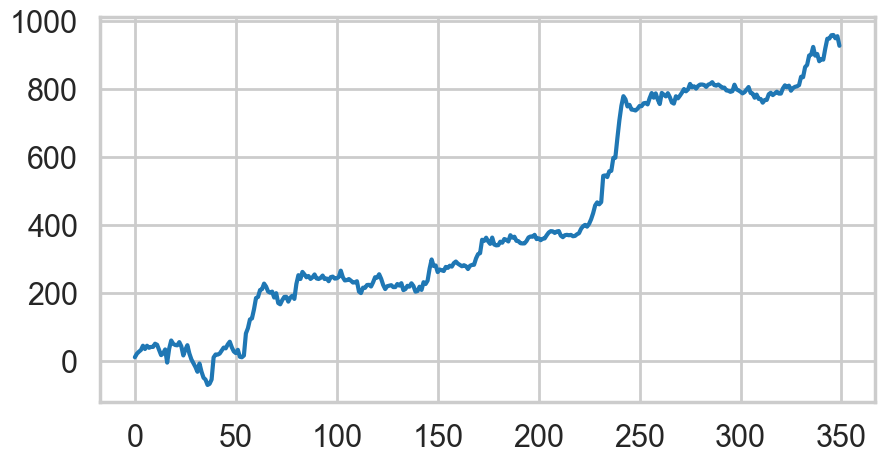

In [618]:

buy = 0 
profit = []
date = []
time = 0
position = []
for i in tqdm(range(len(signal))):
    if buy == 0 and signal.dev.iloc[i] < -3.5 and signal.Open.iloc[i] - signal.Close.iloc[i-4] < 4.5:
        buy = signal.Open.iloc[i]
        position.append(1)
        time = i
        date.append(signal.Date.iloc[i])
    if buy != 0 and i - time >= 1:
        if signal['diff'].iloc[i] > 8 or signal['diff'].iloc[i] < (-35) or (i - time) == 13:
            profit.append(buy - signal.Open.iloc[i])
            date.append(signal.Date.iloc[i])
            position.append(0)
            buy = 0
pd.Series(profit).cumsum().plot(figsize = (10,5))

In [561]:
signal['diff']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
24876   -1.5
24877    3.3
24878    4.1
24879    8.8
24880   -9.1
Name: diff, Length: 24881, dtype: float64

In [492]:
Y_pre = lm.predict(X_train)

In [494]:
X_train['pre'] = Y_pre

C:\Users\Admin\AppData\Local\Temp\ipykernel_11096\2581905173.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['pre'] = Y_pre


In [496]:
X_train['Y'] = Y_train

C:\Users\Admin\AppData\Local\Temp\ipykernel_11096\947465969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Y'] = Y_train


<AxesSubplot:>

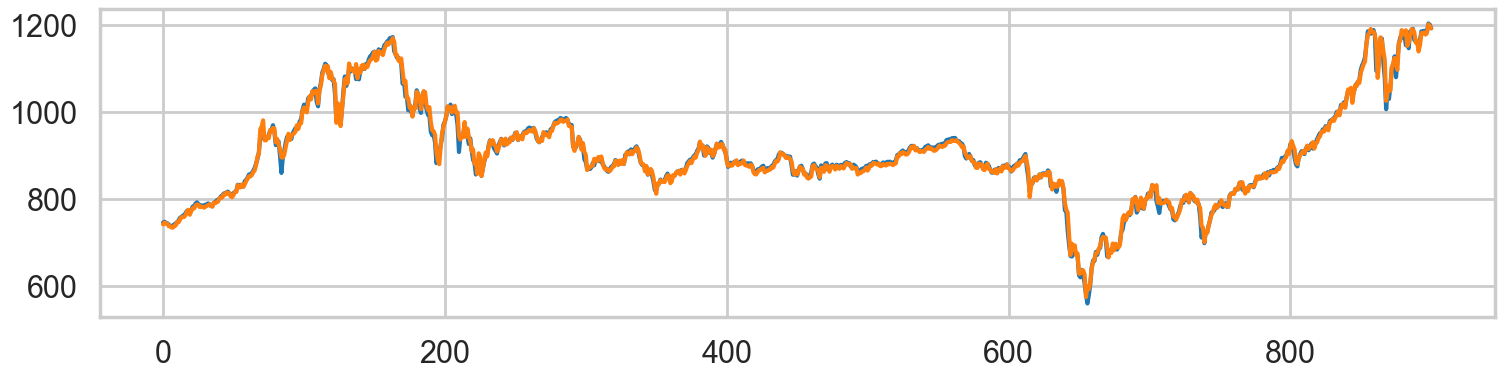

In [498]:
X_train.Y.plot(figsize=(18,4))
X_train.pre.plot(figsize=(18,4))


In [499]:
X_train

Open    9:15    9:30   10:00          pre       Y
0     745.7   746.2   747.0   746.1   741.977940   746.1
1     750.8   749.4   749.6   750.3   746.079571   748.0
2     747.3   747.1   745.7   747.0   743.463221   745.7
3     749.0   748.2   747.6   748.0   743.826398   744.5
4     742.9   742.6   742.4   742.1   737.902649   741.6
..      ...     ...     ...     ...          ...     ...
896  1191.1  1189.5  1189.8  1189.1  1177.983148  1180.2
897  1184.1  1186.0  1185.1  1189.2  1181.843976  1186.8
898  1204.2  1206.7  1209.9  1210.3  1201.446010  1203.5
899  1203.2  1205.5  1205.9  1206.4  1197.279846  1200.6
900  1208.0  1207.3  1208.7  1204.9  1192.478934  1192.4

[901 rows x 6 columns]

In [584]:
signal

Date   Open   High    Low  Close   Volume         Day  dev  \
0      2017-08-10 09:15  757.9  757.9  755.5  755.5     26.0  2017-08-10  0.0   
1      2017-08-10 09:30  755.1  755.1  753.8  753.8     21.0  2017-08-10  0.0   
2      2017-08-10 09:45  753.6  753.6  752.3  752.3     13.0  2017-08-10  0.0   
3      2017-08-10 10:00  752.0  752.0  750.4  750.4     17.0  2017-08-10  0.0   
4      2017-08-10 10:15  750.0  750.0  748.2  748.2     20.0  2017-08-10  0.0   
...                 ...    ...    ...    ...    ...      ...         ...  ...   
24876  2022-11-08 13:30  963.2  970.0  963.2  966.5  35302.0  2022-11-08  0.0   
24877  2022-11-08 13:45  966.5  973.8  965.2  971.0  30439.0  2022-11-08  0.0   
24878  2022-11-08 14:00  970.6  984.7  969.3  979.0  47741.0  2022-11-08  0.0   
24879  2022-11-08 14:15  979.4  979.6  968.8  969.9  41013.0  2022-11-08  0.0   
24880  2022-11-08 14:30  970.3  970.3  970.3  970.3    160.0  2022-11-08  0.0   

       diff  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  
...     ...  
24876  -1.5  
24877   3.3  
24878   4.1  
24879   8.8  
24880  -9.1  

[24881 rows x 9 columns]

In [587]:
per = signal.loc[signal['dev'] != 0]

In [589]:
per['real'] = per['Low'] - per['Open']

C:\Users\Admin\AppData\Local\Temp\ipykernel_11096\2110903682.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per['real'] = per['Low'] - per['Open']


In [590]:
per['persent'] = per.real * per.dev

C:\Users\Admin\AppData\Local\Temp\ipykernel_11096\2456207107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  per['persent'] = per.real * per.dev


In [611]:
len(per.loc[per.persent>=0])/ len(per)

0.9951338199513382

In [593]:
len(per.loc[per.persent == 0])

23